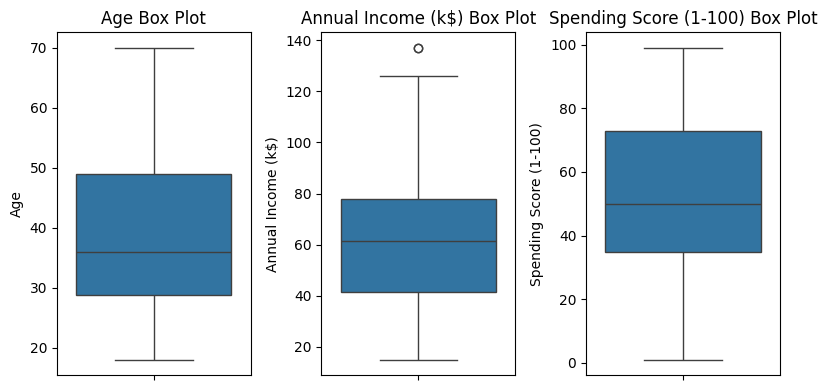

     Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
2     20                  16                       6        False
8     64                  19                       3         True
10    67                  19                      14         True
196   45                 126                      28        False
198   32                 137                      18         True
199   30                 137                      83         True


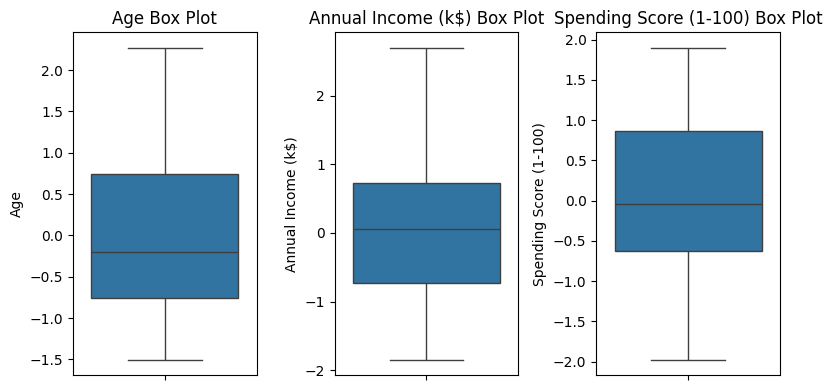

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest # 이상치
from sklearn.preprocessing import StandardScaler # 표준화
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 데이터 불러오기
data = pd.read_csv('Mall_Customers.csv')

# 1. 데이터 전처리
# CustomerID 제거
data = data.drop(columns=['CustomerID'])

# Gender 원-핫 인코딩
data = pd.get_dummies(data, columns=['Gender'], drop_first=True)

# Age, Annual Income, Spending Score의 박스 플롯
plt.figure(figsize=(8, 4))
for i, col in enumerate(['Age', 'Annual Income (k$)', 'Spending Score (1-100)']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=data[col])
    plt.title(f'{col} Box Plot')
plt.tight_layout()
plt.show()

# 2. 이상치 탐지 (Age, Annual Income, Spending Score에만 적용)
iso = IsolationForest(contamination=0.03, random_state=42)
outliers = iso.fit_predict(data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
print(data[outliers != 1])
# 정상 데이터만 유지
data = data[outliers == 1]

# 3. 데이터 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# 기존 열 삭제 및 새로운 데이터 추가
data = data.drop(columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaled_data

# Age, Annual Income, Spending Score의 박스 플롯
plt.figure(figsize=(8, 4))
for i, col in enumerate(['Age', 'Annual Income (k$)', 'Spending Score (1-100)']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=data[col])
    plt.title(f'{col} Box Plot')
plt.tight_layout()
plt.show()


k=2, KMeans=0.30454393665511204, Hierarchical=0.29333731112250383, GMM=0.29638619797699806
k=3, KMeans=0.23072661321080984, Hierarchical=0.309594935265011, GMM=0.2137556316207079
k=4, KMeans=0.2974589739557058, Hierarchical=0.33869192077139904, GMM=0.30303324180855656
k=5, KMeans=0.3628280244152212, Hierarchical=0.3503809162648395, GMM=0.353310883190385
k=6, KMeans=0.3695998433860225, Hierarchical=0.3590868350997984, GMM=0.35593183574585935
k=7, KMeans=0.3571146119694642, Hierarchical=0.31801542049001275, GMM=0.32301980278765424
k=8, KMeans=0.3410764340250818, Hierarchical=0.31501680491110956, GMM=0.327157559747484
k=9, KMeans=0.3328569377430843, Hierarchical=0.2903163319292009, GMM=0.02309338139723048
k=10, KMeans=0.34368832191051674, Hierarchical=0.2681625294529738, GMM=0.022873461471988953
eps=0.5, min_samples=6, Silhouette Score=0.5705
eps=0.5, min_samples=7, Silhouette Score=0.6794
eps=0.5, min_samples=8, Silhouette Score=0.7183
eps=0.6, min_samples=6, Silhouette Score=0.3250
eps=

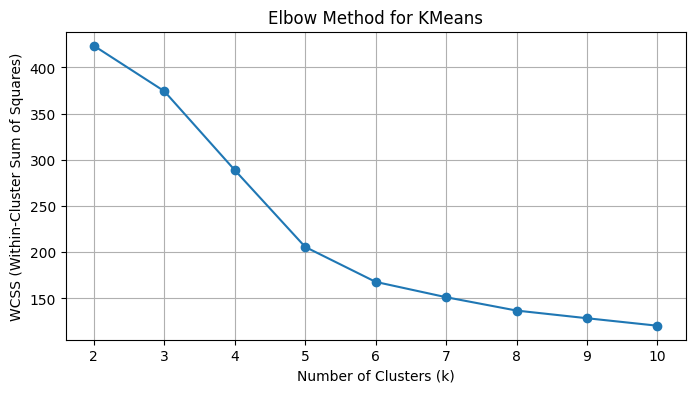

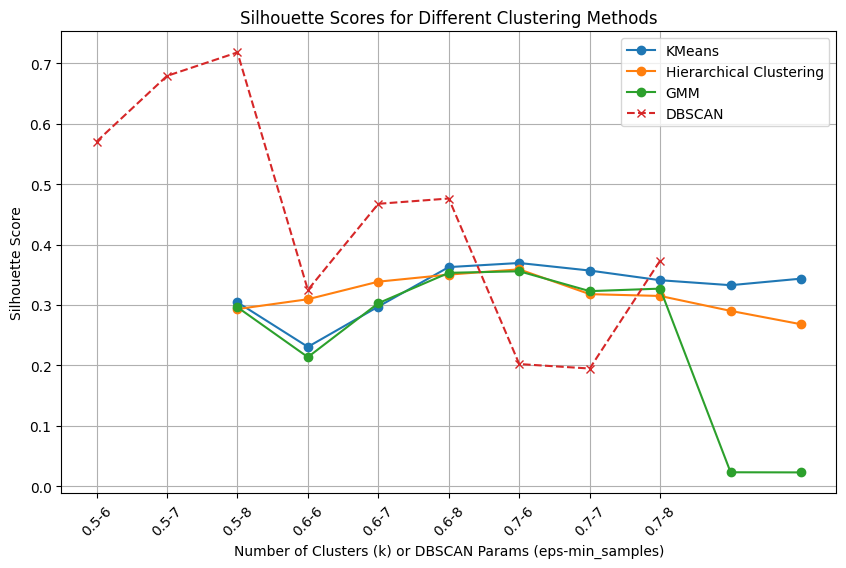

In [ ]:
# 실루엣 점수를 저장할 딕셔너리
silhouette_scores = {
  "KMeans": {},
  "Hierarchical Clustering": {},
  "GMM": {},
  "DBSCAN": {}  # (eps, min_samples) 조합을 키로 사용
}

# 엘보우 방법을 위한 WCSS 저장 리스트
wcss = []

# 실루엣 점수 계산 및 저장
for k in range(2, 11):
  # KMeans
  km = KMeans(n_clusters=k, random_state=42)
  silhouette_scores["KMeans"][k] = silhouette_score(data, km.fit_predict(data))

  wcss.append(km.inertia_)

  # Hierarchical Clustering
  hc = AgglomerativeClustering(n_clusters=k)
  silhouette_scores["Hierarchical Clustering"][k] = silhouette_score(data, hc.fit_predict(data))

  # GMM
  gmm = GaussianMixture(n_components=k, random_state=42)
  silhouette_scores["GMM"][k] = silhouette_score(data, gmm.fit_predict(data))

  print(f"k={k}, KMeans={silhouette_scores['KMeans'][k]}, Hierarchical={silhouette_scores['Hierarchical Clustering'][k]}, GMM={silhouette_scores['GMM'][k]}")

# DBSCAN 파라미터 조합 설정
eps_values = [0.5, 0.6, 0.7]
min_samples_values = [6, 7, 8]

# DBSCAN 점수 계산
dbscan_scores = {}
for eps in eps_values:
  for min_samples in min_samples_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    data['Cluster_DBSCAN'] = dbscan.fit_predict(data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']])

    # 노이즈 제거 (-1 레이블 제외)
    labels = data['Cluster_DBSCAN']
    if len(set(labels)) > 1:  # 최소 2개의 클러스터가 있어야 실루엣 점수 계산 가능
      non_noise_data = data[labels != -1]
      non_noise_labels = labels[labels != -1]
      score = silhouette_score(non_noise_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']], non_noise_labels)
      dbscan_scores[(eps, min_samples)] = score
      silhouette_scores["DBSCAN"][(eps, min_samples)] = score
      print(f"eps={eps}, min_samples={min_samples}, Silhouette Score={score:.4f}")
    else:
      print(f"eps={eps}, min_samples={min_samples}, insufficient clusters (only noise or 1 cluster).")

# 실루엣 점수가 가장 높은 K를 저장
best_k = {}

# KMeans, Hierarchical Clustering, GMM 처리
for method in ["KMeans", "Hierarchical Clustering", "GMM"]:
  scores = silhouette_scores[method]
  best_k[method] = max(scores, key=scores.get)

# DBSCAN 처리
if silhouette_scores["DBSCAN"]:
  best_dbscan_params = max(silhouette_scores["DBSCAN"], key=silhouette_scores["DBSCAN"].get)
  best_k["DBSCAN"] = best_dbscan_params

# 결과 출력
for method, k in best_k.items():
  if method == "DBSCAN":
    print(f"Best params for {method}: eps={k[0]}, min_samples={k[1]} with Silhouette Score: {silhouette_scores[method][k]}")
  else:
    print(f"Best k for {method}: {k} with Silhouette Score: {silhouette_scores[method][k]}")


# 엘보우 방법 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid()
plt.show()

# 실루엣 점수 시각화
plt.figure(figsize=(10, 6))

# KMeans, Hierarchical, GMM 점수 시각화
for method, scores in silhouette_scores.items():
    if method != "DBSCAN":
        plt.plot(scores.keys(), scores.values(), label=method, marker='o')

# DBSCAN 점수 시각화
dbscan_x = [f"{eps}-{min_samples}" for eps, min_samples in silhouette_scores["DBSCAN"].keys()]
dbscan_y = silhouette_scores["DBSCAN"].values()
plt.plot(dbscan_x, dbscan_y, label="DBSCAN", marker='x', linestyle='--')

plt.title('Silhouette Scores for Different Clustering Methods')
plt.xlabel('Number of Clusters (k) or DBSCAN Params (eps-min_samples)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()



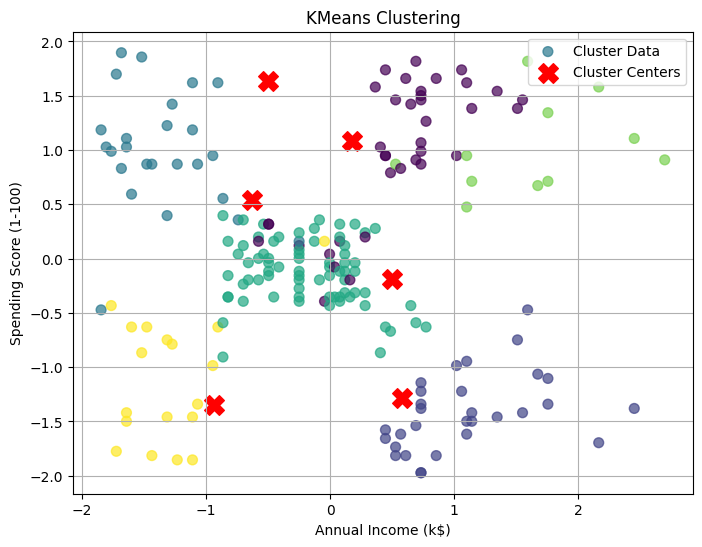

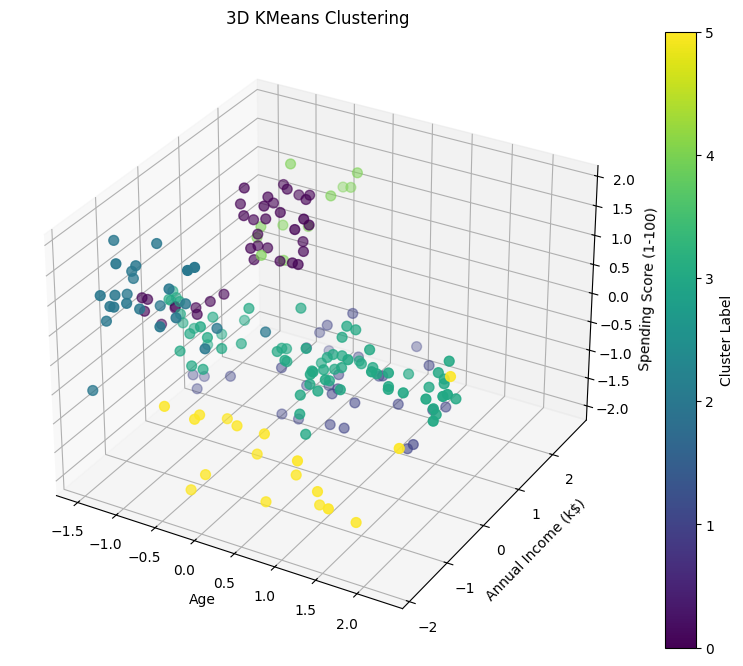

KMeans 실루엣 스코어 = 0.43958810661266556
계층적 군집화 실루엣 스코어 = 0.40715277213177864
DBSCAN 실루엣 스코어 (without noise) = 0.8756496673267996
DBSCAN 데이터 손실 비율: 86.08%
GMM 실루엣 스코어 = 0.3611794217879861


In [ ]:
# 최적 클러스터링 및 점수 확인

# 1. KMeans
kmeans = KMeans(n_clusters=best_k['KMeans'], random_state=42)
kmeans_labels = kmeans.fit_predict(data)
kmeans_score = silhouette_score(data, kmeans_labels)
cluster_centers = kmeans.cluster_centers_

# KMeans 결과 시각화
# KMeans 결과 시각화 (2D Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
            c=kmeans_labels, cmap='viridis', s=50, alpha=0.7, label='Cluster Data')
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 2],
            c='red', marker='X', s=200, label='Cluster Centers')
plt.title('KMeans Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data['Age'], data['Annual Income (k$)'], data['Spending Score (1-100)'],
                      c=kmeans_labels, cmap='viridis', s=50)
ax.set_title('3D KMeans Clustering')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

print(f"KMeans 실루엣 스코어 = {kmeans_score}")


# 2. 계층적 군집화
hc = AgglomerativeClustering(n_clusters=best_k['Hierarchical Clustering'])
hc_labels = hc.fit_predict(data)
hc_score = silhouette_score(data, hc_labels)
print(f"계층적 군집화 실루엣 스코어 = {hc_score}")

# 3. DBSCAN
dbscan = DBSCAN(eps=best_dbscan_params[0], min_samples=best_dbscan_params[1])
dbscan_labels = dbscan.fit_predict(data)

non_noise_data = data[dbscan_labels != -1]
non_noise_labels = dbscan_labels[dbscan_labels != -1]
dbscan_score = silhouette_score(non_noise_data, non_noise_labels)
print(f"DBSCAN 실루엣 스코어 (without noise) = {dbscan_score}")

# DBSCAN 데이터 손실 비율 계산
total_data_points = len(data)  # 전체 데이터 포인트 수
noise_points = len(data[dbscan_labels == -1])  # 노이즈로 분류된 데이터 포인트 수
loss_ratio = noise_points / total_data_points  # 손실 비율 계산

# 손실 비율 출력
print(f"DBSCAN 데이터 손실 비율: {loss_ratio}")

# 4. GMM
gmm = GaussianMixture(n_components=best_k['GMM'], random_state=42)
gmm_labels = gmm.fit_predict(data)
gmm_score = silhouette_score(data, gmm_labels)
print(f"GMM 실루엣 스코어 = {gmm_score}")